# 数据预处理部分
- 包括如下内容 (顺序不分先后)
    - 清洗数据，修复错误单词
    - 数据分析
    - 提取词汇表，准备训练数据
    - 数据增强

## 修复错误单词
- 使用python脚本进行纠错，原理是用编辑距离进行替换
- 脚本参考：https://github.com/percent4/-word-
- 英语词库参考：https://github.com/first20hours/google-10000-english/
- 使用最常使用的词库，因为过于丰富的词库会将某些错词转换为生僻词，某种意义上的过拟合。

    例如：`and thei didn t believ me`中的`thei`应改成`they`, 
    但是会被改为`thein`，因为它们的编辑距离更近


In [4]:
import os
# 将原始数据进行格式转换，用制表符替代空格
os.system('python ./src/trans.py')

1

In [ ]:
# 数据清理
os.system('python ./src/correct.py')

## 训练数据准备
- 提取纠错后的文本文件中的词汇，形成词汇表
- 从全集中读取词汇表(由于测试集中有全集没有的词汇，如果仅用训练集可能会无法量化全集)，生成向量

In [1]:
# 载入库
import sys
import numpy as np
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
# 文件集
file_paths = [
    "./data/ISEAR ID_train_f",
    "./data/ISEAR ID_test_f",
    "./data/ISEAR ID_validation_f"
]
# 存储tensor的文件
save_paths = [
    "./dataset/train_data",
    "./dataset/test_data",
    "./dataset/vali_data"
]


def open_file(filename, mode='r'):
    """
    打开特定文件
    """
    return open(filename, mode, encoding='utf-8', errors='ignore')


def read_file(filename):
    """
    读取文件数据
    """
    contents, labels = [], []
    with open_file(filename) as f:
        for line in f:
            raw = line.strip().split('\t')
            label = [int(raw[i][-1]) for i in range(2, 9)]
            content = raw[-1]
            if content:
                contents.append(content)
                labels.append(label)
    return contents, labels

In [2]:
# 将文件中的数据存储为可训练的向量

def build_vocab(file_path, vocab_path='', vocab_size=10000):
    """
    从语料中提取词汇表并存储到本地
    """
    contents, _ = read_file(file_path)
    all_data = []
    for content in contents:
        all_data.extend(content.split())
    # print(all_data)
    cnt = Counter(all_data)
    cnt_p = cnt.most_common(vocab_size - 1)
    words, _ = list(zip(*cnt_p))
    # 添加美元符号使所有词向量长度一致
    words = ['$'] + list(words)
    if vocab_path:
        open_file(vocab_path, 'w').write('\n'.join(words) + '\n')
    # 返回词汇个数
    return len(words) - 1


def read_vocab(vocab_path):
    """
    读取本地的词汇表
    """
    with open_file(vocab_path) as f:
        words = [_.strip() for _ in f.readlines()]
    word2id = dict(zip(words, range(len(words))))
    return words, word2id


def read_cat():
    """
    读取分类并量化为id
    """
    cats = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
    cat2id = dict(zip(cats, range(len(cats))))

    return cats, cat2id


def id2word(lst, words):
    """
    将id表示的列表映射为文字
    """
    return ' '.join(words[x] for x in lst)


def process_file(file_path, vocab_path):
    """
    将所有的句子转换为id的列表 (向量)
    """

    _, word2id = read_vocab(vocab_path)
    contents, labels = read_file(file_path)

    data_ids, label_ids = [], []
    for i in range(len(contents)):
        lst = contents[i].split()
        data_ids.append([word2id[x] for x in lst if x in word2id])

    # 使用pytorch自带的库将文本pad为相同长度
    x_padded = pad_sequence([torch.from_numpy(np.array(x)) for x in data_ids], batch_first=True)
    y_padded = torch.Tensor(labels)

    return x_padded, y_padded



## 数据分析
- 宏观和微观的分析

In [3]:
# 获取各个数据集的词汇表大小 (清理前)
# ISEAR ID_n是新数据集
# ISEAR ID_b是清理前的数据集
print(build_vocab(
    "./data/ISEAR ID_f", 
    "./dataset/vocab_f.txt",
    ), "all")
print(build_vocab(
    "./data/ISEAR ID_train_f", 
    "",
    ), "train")
print(build_vocab(
    "./data/ISEAR ID_test_f", 
    "",
    ), "test")
print(build_vocab(
    "./data/ISEAR ID_validation_f", 
    "",
    ), "validation")


4954 all
4106 train
2626 test
2601 validation


No handles with labels found to put in legend.


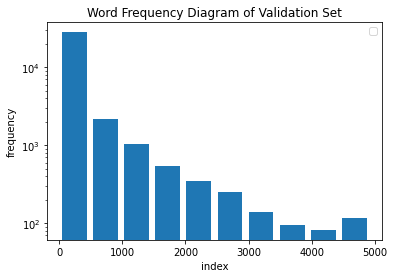

In [7]:
# 得到词频分布
def plot_freq(file_path, fig_path, vocab_path, fig_title, vocab_size=10000):
    '''
    画出各个数据集的词频分布
    '''
    contents, _ = read_file(file_path)
    all_data = []
    for content in contents:
        all_data.extend(content.split())
    _, word2id = read_vocab(vocab_path)
    words_id = []
    words_id.extend([word2id[x] for x in all_data if x in word2id])
    # tmp = list(zip(words_id, times))
    # tmp.sort(key=lambda x:x[0])
    # words_id, times = list(zip(*tmp))    
    # times = list(times)
    # print(times)
    # for i in range(len(times)):
    #     times[i] = np.log2(times[i])
    plt.yscale('log')
    plt.hist(words_id, 10, histtype='bar', rwidth=0.8)
    plt.legend()
    plt.xlabel('index')
    plt.ylabel('frequency')
    plt.title(fig_title)
    plt.show()
    plt.close()

# 从全集中读取词汇表 (清理前)
# build_vocab(
#     "./data/ISEAR ID_b", 
#     "./dataset/vocab_b.txt",
#     )

plot_freq(
    "./data/ISEAR ID_validation_f",
    "",
    "./dataset/vocab_f.txt",
    "Word Frequency Diagram of Validation Set"
)


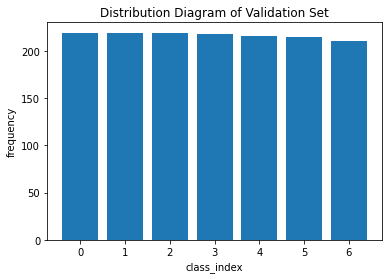

In [15]:
# 得到句子类别分布
def plot_class(file_path, fig_title):
    _, labels = read_file(file_path)
    cnt = [0 for i in range(7)]
    for label in labels:
        for i in range(len(label)):
            if label[i] == 1:
                cnt[i] += 1
    plt.bar(list(range(7)), cnt)
    plt.xlabel('class_index')
    plt.ylabel('frequency')
    plt.title(fig_title)
    plt.show()
    plt.close()

plot_class(
    "./data/ISEAR ID_validation_f",
    "Distribution Diagram of Validation Set"
)

No handles with labels found to put in legend.


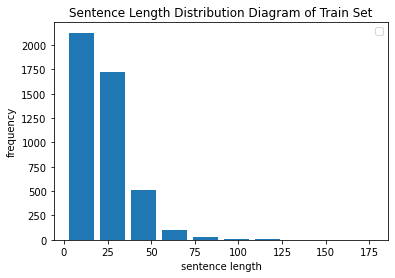

179

In [17]:
# 得到句子长度分布
def plot_len(file_path, fig_title):
    contents, _ = read_file(file_path)
    all_size = []
    for content in contents:
        all_size.append(len(content.split()))
    # plt.yscale('log')
    plt.hist(all_size, 10, histtype='bar', rwidth=0.8)
    plt.legend()
    plt.xlabel('sentence length')
    plt.ylabel('frequency')
    plt.title(fig_title)
    plt.show()
    plt.close()
    return max(all_size)

plot_len(
    "./data/ISEAR ID_train_f",
    "Sentence Length Distribution Diagram of Train Set"
)

In [26]:
# 数据提取
# 从全集中读取词汇表
# build_vocab(
#     "./data/ISEAR ID_f",  
#     "./dataset/vocab_f.txt",
#     )
# 转换为tensor并存储
# for i in range(len(file_paths)):

x, y = process_file(
    "./data/all", 
    "./dataset/vocab_f.txt"
)
print(type(x), len(x))
torch.save(x[0:4507], save_paths[0] + "_x.pt")
torch.save(y[0:4507], save_paths[0] + "_y.pt")

torch.save(x[4507:4507+1503], save_paths[1] + "_x.pt")
torch.save(y[4507:4507+1503], save_paths[1] + "_y.pt")

torch.save(x[4507+1503:4507+1503+1516], save_paths[2] + "_x.pt")
torch.save(y[4507+1503:4507+1503+1516], save_paths[2] + "_y.pt")


<class 'torch.Tensor'> 7526
torch.Size([7526, 179])
